In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
import itertools
from sklearn import preprocessing

import time

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [33]:
df = pd.read_csv('Kickstarter.csv')
df = df.sample(frac=0.01)
df = df.drop(['ID', 'name'], axis=1)
df['deadline'] = pd.to_datetime(df['deadline'])
df['launched'] = pd.to_datetime(df['launched'])
df['duration'] = df['deadline'] - df['launched']
#df['pledged_percentage'] = df['pledged']/df['goal']
actual_conditions = [
    (df['state'] == 'failed'), (df['state'] == 'canceled'), (df['state'] == 'successful')  ]

choices = [-1, 0, 1]
df['Result'] = np.select(actual_conditions, choices, default=0)
#df['usd pledged'] = np.where(df['currency']=='USD', df['pledged'], df['usd pledged'])
df['deadline'] = [x.year for x in df['deadline']]
df['duration'] = (df['duration'] / np.timedelta64(1, 'D')).astype(int)
df = df.drop(['pledged', 'state','country', 'launched', 'usd pledged'], axis=1)

category = preprocessing.LabelEncoder()
category.fit(df['category'])
df['category'] = category.transform(df['category']) 

main_category = preprocessing.LabelEncoder()
main_category.fit(df['main_category'])
df['main_category'] = main_category.transform(df['main_category']) 

currency = preprocessing.LabelEncoder()
currency.fit(df['currency'])
df['currency'] = currency.transform(df['currency']) 

df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how='any')

In [34]:
#df = df.sample(frac=0.02)

In [4]:
# cancelled_df = df[df['Result']==0].sample(n=1000)
# failed_df = df[df['Result']==-1].sample(n=1000)
# successful_df = df[df['Result']==1].sample(n=1000)

# frames = [cancelled_df, failed_df, successful_df]

# df = pd.concat(frames)

In [36]:
features = list(df.columns[0:-1])
X = df[features]
Y = df['Result']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, shuffle=True)

# 1. Decision Tree

In [58]:
tuned_parameters = [{'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10, 20],
                     'min_samples_leaf': [2, 5, 10]}]

DT = GridSearchCV(DecisionTreeClassifier(), tuned_parameters, cv=10)
start = time.time()

DT.fit(X_train, Y_train)

print(DT.best_params_)

DT_Ypreds = DT.predict(X_test)
DT_Ypreds_training = DT.predict(X_train)

DT_Training_Accuracy = accuracy_score(Y_train, DT_Ypreds_training)
DT_Testing_Accuracy = accuracy_score(Y_test, DT_Ypreds)

print ("Training Accuracy: %0.3f" % DT_Training_Accuracy)
print ("Testing Accuracy: %0.3f" % DT_Testing_Accuracy)

end = time.time()

DT_time = end - start
print ("Time: %0.2f" % DT_time)

{'min_samples_split': 2, 'max_depth': 5, 'min_samples_leaf': 5}
Training Accuracy: 0.830
Testing Accuracy: 0.808
Time: 3.35


# 2. Neural Networks (Multi-layer Perceptron (MLP) )

In [59]:
tuned_parameters = [{'hidden_layer_sizes':[(10, 5), (4, 20), (8, 20), (4, 30), (10, 40)]}]

Xtrain_scaled = pd.DataFrame(preprocessing.scale(X_train))
Xtest_scaled = pd.DataFrame(preprocessing.scale(X_test))

NN = GridSearchCV(MLPClassifier(), tuned_parameters, cv = 8)
start = time.time()
NN.fit(Xtrain_scaled, Y_train)

print(NN.best_params_)

NN_Ypreds = NN.predict(Xtest_scaled)
NN_Ypreds_training = NN.predict(Xtrain_scaled)

NN_Training_Accuracy = accuracy_score(Y_train, NN_Ypreds_training)
NN_Testing_Accuracy = accuracy_score(Y_test, NN_Ypreds)

print ("Training Accuracy: %0.3f" % NN_Training_Accuracy)
print ("Testing Accuracy: %0.3f" % NN_Testing_Accuracy)

end=time.time()

NN_time = end - start
print ("Time: %0.2f" % NN_time)

{'hidden_layer_sizes': (4, 20)}
Training Accuracy: 0.795
Testing Accuracy: 0.772
Time: 49.51


# 3. Boost (AdaBoost on Decision Trees)

In [60]:
tuned_parameters = [{
    'base_estimator':[DecisionTreeClassifier(max_depth=5, min_samples_split=5, min_samples_leaf=10)], 
    'n_estimators':[5, 10, 20, 30], 
    'learning_rate':[1, 0.8, 0.5, 0.3, 0.2, 0.1]
}]

Boost = GridSearchCV(AdaBoostClassifier(), tuned_parameters, cv = 10)

start = time.time()

Boost.fit(X_train, Y_train)

print(Boost.best_params_)

Boost_Ypreds = Boost.predict(X_test)
Boost_Ypreds_training = Boost.predict(X_train)

Boost_Training_Accuracy = accuracy_score(Y_train, Boost_Ypreds_training)
Boost_Testing_Accuracy = accuracy_score(Y_test, Boost_Ypreds)

print ("Training Accuracy: %0.3f" % Boost_Training_Accuracy)
print ("Testing Accuracy: %0.3f" % Boost_Testing_Accuracy)

end=time.time()

Boost_time = end - start
print ("Time: %0.2f" % Boost_time)

{'n_estimators': 5, 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'learning_rate': 0.1}
Training Accuracy: 0.840
Testing Accuracy: 0.798
Time: 26.95


# 4. SVM

In [61]:
tuned_parameters = [{
    'kernel':('rbf', 'sigmoid'), 
    'gamma': [0.1, 0.01, 0.001, 0.0001],
    'C':[10, 100, 1000, 10000, 100000]
}]


SVM = GridSearchCV(SVC(), tuned_parameters)
start = time.time()

SVM.fit(X_train, Y_train)

print(SVM.best_params_)

SVM_Ypreds = SVM.predict(X_test)
SVM_Ypreds_training = SVM.predict(X_train)

SVM_Training_Accuracy = accuracy_score(Y_train, SVM_Ypreds_training)
SVM_Testing_Accuracy = accuracy_score(Y_test, SVM_Ypreds)

print ("Training Accuracy: %0.3f" % SVM_Training_Accuracy)
print ("Testing Accuracy: %0.3f" % SVM_Testing_Accuracy)

end=time.time()

SVM_time = end - start
print ("Time: %0.2f" % SVM_time)

{'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}
Training Accuracy: 0.881
Testing Accuracy: 0.741
Time: 19.85


# 5. KNN

In [62]:

tuned_parameters = [{
    'n_neighbors': [2, 3, 5, 10, 20, 30, 40]
}]

KNN = GridSearchCV(KNeighborsClassifier(), tuned_parameters)

start = time.time()
KNN.fit(X_train, Y_train)

print(KNN.best_params_)

KNN_Ypreds = KNN.predict(X_test)
KNN_Ypreds_training = KNN.predict(X_train)

KNN_Training_Accuracy = accuracy_score(Y_train, KNN_Ypreds_training)
KNN_Testing_Accuracy = accuracy_score(Y_test, KNN_Ypreds)

print ("Training Accuracy: %0.3f" % KNN_Training_Accuracy)
print ("Testing Accuracy: %0.3f" % KNN_Testing_Accuracy)

end=time.time()

KNN_time = end - start
print ("Time: %0.2f" % KNN_time)

{'n_neighbors': 5}
Training Accuracy: 0.805
Testing Accuracy: 0.734
Time: 0.44


## II. Model Comparison

## 1. ROC Curves

In [63]:
times = [DT_time, NN_time, Boost_time, SVM_time, KNN_time]
Training_Accuracy = [DT_Training_Accuracy, NN_Training_Accuracy, Boost_Training_Accuracy, SVM_Training_Accuracy, KNN_Training_Accuracy]
Testing_Accuracy = [DT_Testing_Accuracy, NN_Testing_Accuracy, Boost_Testing_Accuracy, SVM_Testing_Accuracy, KNN_Testing_Accuracy]

result = pd.DataFrame([times, Training_Accuracy, Testing_Accuracy], columns=["Decision Tree", "Neural Network", "AdaBoost", "SVM", "KNN"], index=['Running Time (seconds)', 'Traing Accuracy', 'Testing Accuracy'])


In [64]:
result

,Decision Tree,Neural Network,AdaBoost,SVM,KNN
Running Time (seconds),3.35323,49.509973,26.948161,19.849457,0.438835
Traing Accuracy,0.82972,0.795428,0.839574,0.880568,0.805282
Testing Accuracy,0.80800,0.772000,0.798400,0.740800,0.734400


In [65]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[620   1  44]
 [132   2  14]
 [ 49   0 388]]
Normalized confusion matrix
[[ 0.93  0.    0.07]
 [ 0.89  0.01  0.09]
 [ 0.11  0.    0.89]]
Confusion matrix, without normalization
[[590   4  71]
 [133   1  14]
 [ 63   0 374]]
Normalized confusion matrix
[[ 0.89  0.01  0.11]
 [ 0.9   0.01  0.09]
 [ 0.14  0.    0.86]]
Confusion matrix, without normalization
[[616   1  48]
 [136   2  10]
 [ 56   1 380]]
Normalized confusion matrix
[[ 0.93  0.    0.07]
 [ 0.92  0.01  0.07]
 [ 0.13  0.    0.87]]
Confusion matrix, without normalization
[[588  23  54]
 [130   6  12]
 [ 99   6 332]]
Normalized confusion matrix
[[ 0.88  0.03  0.08]
 [ 0.88  0.04  0.08]
 [ 0.23  0.01  0.76]]
Confusion matrix, without normalization
[[595  25  45]
 [129   9  10]
 [115   8 314]]
Normalized confusion matrix
[[ 0.89  0.04  0.07]
 [ 0.87  0.06  0.07]
 [ 0.26  0.02  0.72]]


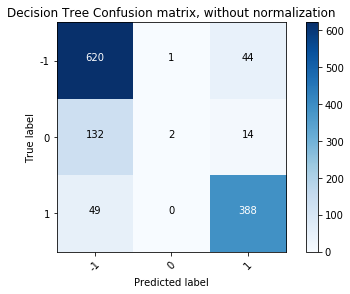

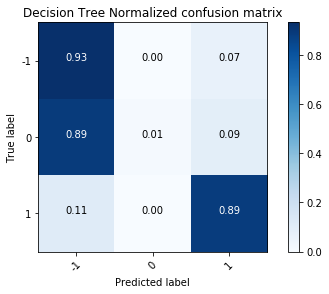

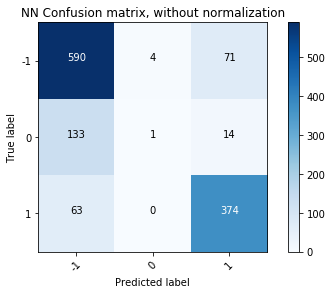

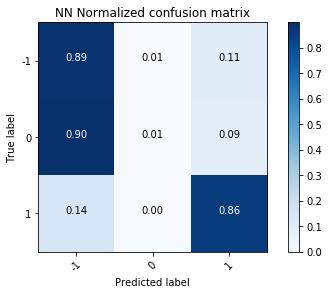

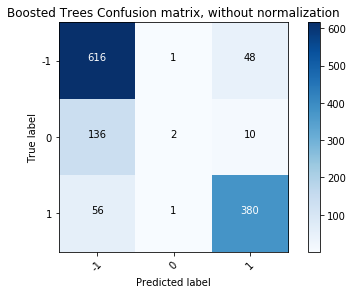

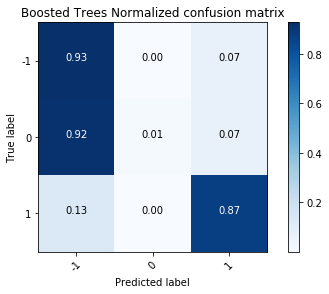

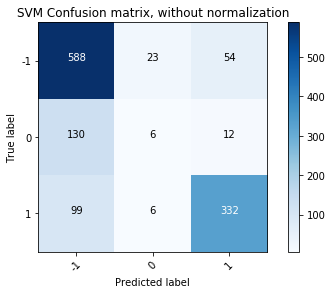

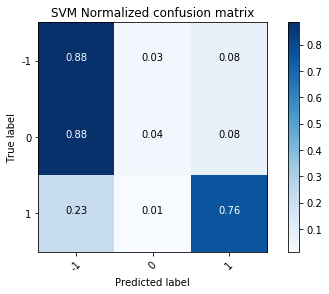

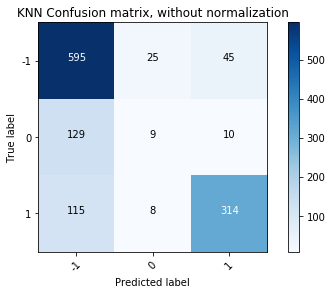

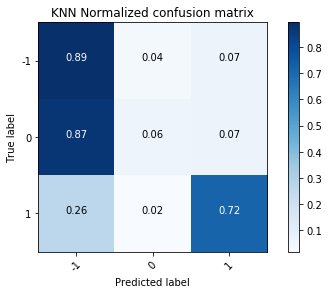

In [66]:
class_names = [-1, 0, 1]

DT_cnf_matrix = confusion_matrix(Y_test, DT_Ypreds)
np.set_printoptions(precision=2)

####################################################################

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(DT_cnf_matrix, classes=class_names,
                      title='Decision Tree Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(DT_cnf_matrix, classes=class_names, normalize=True,
                      title='Decision Tree Normalized confusion matrix')
####################################################################

NN_cnf_matrix = confusion_matrix(Y_test, NN_Ypreds)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(NN_cnf_matrix, classes=class_names,
                      title='NN Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(NN_cnf_matrix, classes=class_names, normalize=True,
                      title='NN Normalized confusion matrix')
####################################################################

Boost_cnf_matrix = confusion_matrix(Y_test, Boost_Ypreds)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(Boost_cnf_matrix, classes=class_names,
                      title='Boosted Trees Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(Boost_cnf_matrix, classes=class_names, normalize=True,
                      title='Boosted Trees Normalized confusion matrix')
####################################################################

SVM_cnf_matrix = confusion_matrix(Y_test, SVM_Ypreds)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(SVM_cnf_matrix, classes=class_names,
                      title='SVM Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(SVM_cnf_matrix, classes=class_names, normalize=True,
                      title='SVM Normalized confusion matrix')
####################################################################
KNN_cnf_matrix = confusion_matrix(Y_test, KNN_Ypreds)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(KNN_cnf_matrix, classes=class_names,
                      title='KNN Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(KNN_cnf_matrix, classes=class_names, normalize=True,
                      title='KNN Normalized confusion matrix')

plt.show()

In [67]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

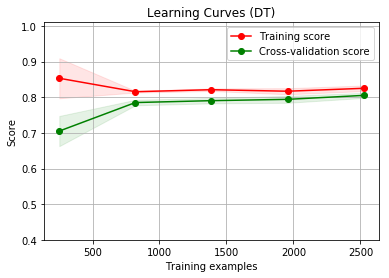

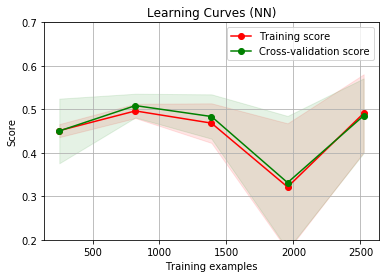

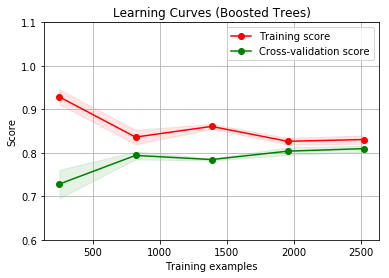

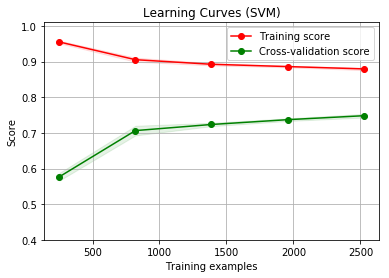

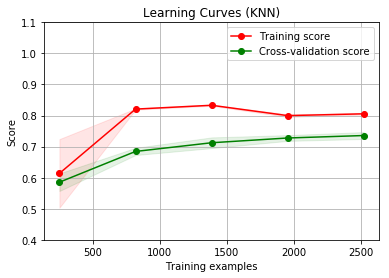

449.353057861


In [68]:
start= time.time()
title = "Learning Curves (DT)"
plot_learning_curve(DT, title, X, Y, ylim=(0.4, 1.01))
####################################################################

title = "Learning Curves (NN)"
plot_learning_curve(NN, title, X, Y, (0.2, 0.7))

####################################################################

title = "Learning Curves (Boosted Trees)"
plot_learning_curve(Boost, title, X, Y, (0.6, 1.1))

####################################################################

title = "Learning Curves (SVM)"
plot_learning_curve(SVM, title, X, Y, (0.4, 1.01))
####################################################################

title = "Learning Curves (KNN)"
plot_learning_curve(KNN, title, X, Y, (0.4, 1.1))
####################################################################

plt.show()

end= time.time()
print end-start